In [1]:
import pandas as pd
import numpy as np


data = pd.read_csv('Main_dataset.csv')


data.drop_duplicates(inplace=True)


data.info()


categorical_columns = ['SoilType', 'PHRange', 'SalinityLevel', 'PlantType']
for col in categorical_columns:
    data[col] = data[col].astype('category')


data.to_csv('Cleaned_PlantData.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
Index: 5819 entries, 0 to 5965
Data columns (total 42 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlantID                    5819 non-null   int64  
 1   PlantName                  5819 non-null   object 
 2   PlantDescription           5819 non-null   object 
 3   SoilTextureID              5819 non-null   int64  
 4   PHRangeID                  5819 non-null   int64  
 5   OrganicMatterID            5819 non-null   int64  
 6   SalinityLevelID            5819 non-null   int64  
 7   ZoneID                     5819 non-null   int64  
 8   HumidityID                 5819 non-null   int64  
 9   PlantTypeID                5819 non-null   int64  
 10  PlantVarietyID             5781 non-null   float64
 11  PlantID:1                  5781 non-null   float64
 12  PlantVarietyName           5781 non-null   object 
 13  PlantVarietyDescription    5781 non-null   object 
 1

In [2]:
'''extracted the required tables in CSV file by doing left join got 5967 rows and later added missing values searching in Food Agriculture organization and in google'''

'extracted the required tables in CSV file by doing left join got 5967 rows and later added missing values searching in Food Agriculutre organization and in google'

/Users/saisudheerm/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


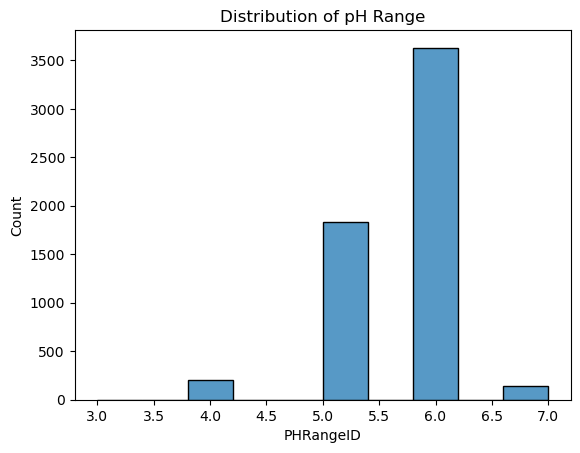

/Users/saisudheerm/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


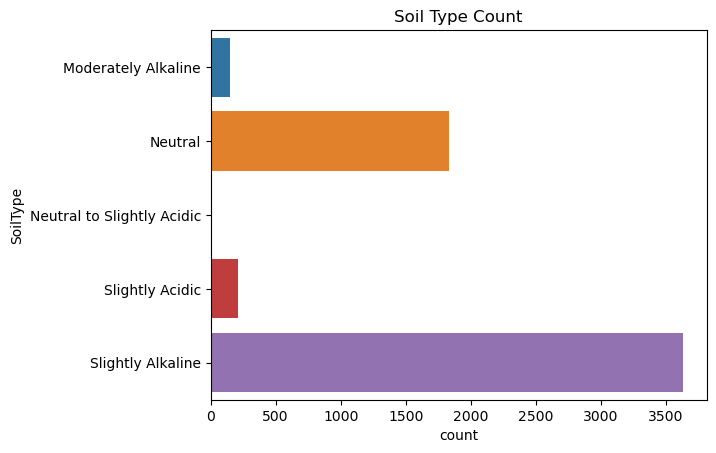

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.histplot(data['PHRangeID'], bins=10)
plt.title('Distribution of pH Range')
plt.show()

sns.countplot(y=data['SoilType'])
plt.title('Soil Type Count')
plt.show()


In [4]:
from sklearn.preprocessing import LabelEncoder


label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le


data['TemperatureRange'] = data['TemperatureEndRange'] - data['TemperatureStartRange']
data['HumidityAvg'] = (data['HumidityLevelLow'] + data['HumidityLevelHigh']) / 2


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


X = data[['PHRangeID', 'SoilTextureID', 'OrganicMatterID', 'SalinityLevelID', 'TemperatureRange', 'HumidityAvg']]
y = data['PlantTypeID']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred, average="weighted")}')
print(f'F1-Score: {f1_score(y_test, y_pred, average="weighted")}')


Accuracy: 0.6589347079037801
Precision: 0.7590527923524892
Recall: 0.6589347079037801
F1-Score: 0.6299488969101291


In [6]:
from dash import Dash, html, dcc, Input, Output
import pandas as pd

app = Dash(__name__)


app.layout = html.Div([
    html.H1('Crop Recommendation Dashboard'),
    dcc.Input(id='ph-input', type='number', placeholder='Enter pH Range ID'),
    dcc.Input(id='soil-input', type='number', placeholder='Enter Soil Texture ID'),
    dcc.Input(id='organic-input', type='number', placeholder='Enter Organic Matter ID'),
    dcc.Input(id='salinity-input', type='number', placeholder='Enter Salinity Level ID'),
    dcc.Input(id='temp-start-input', type='number', placeholder='Enter Temperature Start Range'),
    dcc.Input(id='temp-end-input', type='number', placeholder='Enter Temperature End Range'),
    dcc.Input(id='humidity-low-input', type='number', placeholder='Enter Humidity Level Low'),
    dcc.Input(id='humidity-high-input', type='number', placeholder='Enter Humidity Level High'),
    html.Button('Predict', id='predict-btn'),
    html.Div(id='prediction-output')
])


@app.callback(
    Output('prediction-output', 'children'),
    [Input('predict-btn', 'n_clicks')],
    [Input('ph-input', 'value'), Input('soil-input', 'value'),
     Input('organic-input', 'value'), Input('salinity-input', 'value'),
     Input('temp-start-input', 'value'), Input('temp-end-input', 'value'),
     Input('humidity-low-input', 'value'), Input('humidity-high-input', 'value')]
)
def predict(n_clicks, ph, soil, organic, salinity, temp_start, temp_end, humidity_low, humidity_high):
    if n_clicks:
       
        temp_range = temp_end - temp_start
        humidity_avg = (humidity_low + humidity_high) / 2
        

        input_data = pd.DataFrame([[ph, soil, organic, salinity, temp_range, humidity_avg]],
                                  columns=['PHRangeID', 'SoilTextureID', 'OrganicMatterID', 
                                           'SalinityLevelID', 'TemperatureRange', 'HumidityAvg'])
  
        prediction = model.predict(input_data)[0] 
        return f'Recommended Plant Type ID: {prediction}'
    return 'Enter inputs and click Predict.'


if __name__ == '__main__':
    app.run_server(debug=True)
